In [1]:
--******RUN-1 PARAMETERS*****--

---- Instead of 10-way classification its performs BINARY CLASSIFICATION over image pairs
require 'xlua'
require 'optim'
require 'nn'
require 'cunn'
model_utils = require 'model_utils'
dofile './provider.lua'
c = require 'trepl.colorize'
require 'image'
require 'csvigo'

cmd_params = {}
----- from the opt settings ------
cmd_params.save = 'logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat'
cmd_params.batchSize = 128
cmd_params.learningRate = 1
cmd_params.learningRateDecay = 1e-7
cmd_params.weightDecay = 0.0005
cmd_params.momentum = 0.9
cmd_params.epochStep = 25

cmd_params.mlocal_1 = ''
cmd_params.mlocal_2 = ''
cmd_params.mlocal_3 = ''
cmd_params.mglobal_3 = ''
cmd_params.matten_1 = ''
cmd_params.matten_2 = ''
cmd_params.matten_3 = ''
cmd_params.mmatch = ''
----------------------------------
cmd_params.max_epoch = 300
cmd_params.backend = 'nn'
cmd_params.type = 'cuda'
----------------------------------
cmd_params.gpumode = 1
cmd_params.gpu_setDevice = 1


In [2]:
function cast(t)
   if cmd_params.type == 'cuda' then
      require 'cunn'
        gpumode = cmd_params.gpumode
        if gpumode==1 then
            cutorch.setDevice(cmd_params.gpu_setDevice)
        end
      return t:cuda()
   elseif cmd_params.type == 'float' then
      return t:float()
   elseif cmd_params.type == 'cl' then
      require 'clnn'
      return t:cl()
   else
      error('Unknown type '..cmd_params.type)
   end
end

In [3]:
local seed = 1234567890
torch.manualSeed(seed)
train_or_val = cmd_params.train_or_val

In [4]:
----Data Augmentation
function data_aug(input)
      local bs = input:size(1)
      local flip_mask = torch.randperm(bs):le(bs/2)
      for i=1,input:size(1) do
        if flip_mask[i] == 1 then image.hflip(input[i], input[i]) end
      end    
    return input
    
end

==> loading data	


{
  data : FloatTensor - size: 11x3x32x32
  size : function: 0x40863148
  labels : DoubleTensor - size: 11x1
}


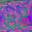

 1
[torch.DoubleTensor of size 1]



In [5]:
----Initiation
require 'nngraph'
--1. Data loading
print(c.blue '==>' ..' loading data')

--provider = torch.load './dataset/cifar100_whitened.t7'  ---sjmod
provider = torch.load './dataset/norms/bear_bearperson_norm.t7' ---sjmod
provider.trainData.data = provider.trainData.data:float()
provider.testData.data = provider.testData.data:float()
print(provider.testData)
itorch.image(provider.testData.data[1]:squeeze())
print(provider.testData.labels[1])

In [6]:


-------------------------------------------------------------------------------------------------
--2. Model creation
mlocal1_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/mlocal_1.net')
mlocal_1 = nn.Sequential()
mlocal_1:add(cast(nn.Copy('torch.FloatTensor', torch.type(cast(torch.Tensor())))))
--mlocal_1:add(cast(dofile('models/'..cmd_params.mlocal_1..'.lua')))
mlocal_1:add(mlocal1_wts)
mlocal_1:get(1).updateGradInput = function(input) return end
if cmd_params.backend == 'cudnn' then
   require 'cudnn'
   cudnn.convert(mlocal_1:get(2), cudnn)
end

mlocal2_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/mlocal_2.net')
mlocal_2 = nn.Sequential()
--mlocal_2:add(cast(dofile('models/'..cmd_params.mlocal_2..'.lua')))
mlocal_2:add(mlocal2_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mlocal_2:get(1), cudnn)
end

mlocal3_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/mlocal_3.net')
mlocal_3 = nn.Sequential()
--mlocal_3:add(cast(dofile('models/'..cmd_params.mlocal_3..'.lua')))
mlocal_3:add(mlocal3_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mlocal_3:get(1), cudnn)
end
-------------------------------------------------------------------------------------------------
mglobal3_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/mglobal_3.net')
mglobal_3 = nn.Sequential()
--mglobal_3:add(cast(dofile('models/'..cmd_params.mglobal_3..'.lua')))
mglobal_3:add(mglobal3_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mglobal_3:get(1), cudnn)
end
-------------------------------------------------------------------------------------------------

matten1_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/matten_1.net')
matten_1 = nn.Sequential()
--matten_1:add(cast(dofile('models/'..cmd_params.matten_1..'.lua')))
matten_1:add(matten1_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(matten_1:get(1),cudnn)
end

matten2_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/matten_2.net')
matten_2 = nn.Sequential()
--matten_2:add(cast(dofile('models/'..cmd_params.matten_2..'.lua')))
matten_2:add(matten2_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(matten_2:get(1),cudnn)
end

matten3_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/matten_3.net')
matten_3 = nn.Sequential()
--matten_3:add(cast(dofile('models/'..cmd_params.matten_3..'.lua')))
matten_3:add(matten3_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(matten_3:get(1),cudnn)
end
-------------------------------------------------------------------------------------------------

mmatch_wts = torch.load('./weights/3atten_e-7_3levels_1global_cifar100/mmatch.net')
mmatch = nn.Sequential()
--mmatch:add(cast(dofile('models/' ..cmd_params.mmatch..'.lua')))
mmatch:add(mmatch_wts)
if cmd_params.backend == 'cudnn' then
    cudnn.convert(mmatch:get(1), 'cudnn')
end


--3. Criterion
print(c.blue'==>' ..' setting criterion')
criterion = cast(nn.CrossEntropyCriterion())

--4. Testing and saving
confusion = optim.ConfusionMatrix(100)
print('Will save at '..cmd_params.save)
paths.mkdir(cmd_params.save)
testLogger = optim.Logger(paths.concat(cmd_params.save, 'test.log'))
testLogger:setNames{'% mean class accuracy (train set)', '% mean class accuracy (test set)'}
testLogger.showPlot = false

-------------------------------------------------------------------------------------------------

--5. Learning settings
print(c.blue'==>' ..' configuring optimizer')
optimState = {
  learningRate = cmd_params.learningRate,
  weightDecay = cmd_params.weightDecay,
  momentum = cmd_params.momentum,
  learningRateDecay = cmd_params.learningRateDecay,
}

==> setting criterion	
Will save at logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat	


==> configuring optimizer	


In [7]:
--test_unnorm = torch.load('/home/torrvision/zbs-torch/projects/cifar.torch/cifar100-test.t7')

In [8]:
function test()
  -- disable flips, dropouts and batch normalization
    mlocal_1:evaluate()
    mlocal_2:evaluate()
    mlocal_3:evaluate()
    mglobal_3:evaluate()    
    matten_1:evaluate() 
    matten_2:evaluate() 
    matten_3:evaluate()   
    mmatch:evaluate()

  -- Get the GLOBAL FEATURE from the TEMPLATE (first image in the testset)
    local l1 = mlocal_1:forward(provider.testData.data:narrow(1,1,1))           
    itorch.image(provider.testData.data:narrow(1,1,1))
    local l2 = mlocal_2:forward(l1)           
    local l3 = mlocal_3:forward(l2)           
    local g = mglobal_3:forward(l3)
    -- clone the global vector --
    local gmain = g:clone()
    --print(gmain:sub(1,10))
    --print(gmain:size())  

  -- Set up the TEST-BENCH and run it for CO-SEG
    print(c.blue '==>'.." testing")
    local bs = 1
    local nsamples = 11 --provider.testData.data:size(1)
    --fv_output = torch.zeros(nsamples,1280)
    
 for i=2,nsamples,bs do 
    local lfeat_1 = mlocal_1:forward(provider.testData.data:narrow(1,i,bs)) 
    local lfeat_2 = mlocal_2:forward(lfeat_1)           
    local lfeat_3 = mlocal_3:forward(lfeat_2)                              
    
    local gmain_re = mglobal_3:forward(lfeat_3)        
    
    local att_con_1 = matten_1:forward({lfeat_1,gmain_re}) -- ensure the use of gmain
    local att_con_2 = matten_2:forward({lfeat_2,gmain_re}) -- ensure the use of gmain
    local att_con_3 = matten_3:forward({lfeat_3,gmain_re}) -- ensure the use of gmain
    
    --itorch.image(provider.testData.data:narrow(1,i,bs))
    --print(gmain[1][1])print(gmain[1][2])print(gmain[1][3])print(gmain[1][4])print(gmain[1][5])  
    --print(lfeat_1[1][2][1])
    gmain_re = gmain_re:squeeze()
    print(gmain_re:size())
    print(gmain_re:sub(1,5))
    --print(provider.testData.labels:narrow(1,i,bs))
------------1. Visualizations

    itorch.image(image.scale(att_con_1[1]:float(),64,64))
    itorch.image(image.scale(att_con_2[1]:float(),64,64))
    itorch.image(image.scale(att_con_3[1]:float(),64,64))
    itorch.image(provider.testData.data:narrow(1,i,bs))
    --[[        
    image.save(string.format('%s/%03d_%s',cmd_params.save,i,'1.png'),att_con_1[1]:float())
    image.save(string.format('%s/%03d_%s',cmd_params.save,i,'2.png'),att_con_2[1]:float())
    image.save(string.format('%s/%03d_%s',cmd_params.save,i,'3.png'),att_con_3[1]:float())
    --]]           
    csvigo.save(string.format('%s/%03d_%s',cmd_params.save,i,'1.txt'),att_con_1[1]:squeeze():double():totable())
    csvigo.save(string.format('%s/%03d_%s',cmd_params.save,i,'2.txt'),att_con_2[1]:squeeze():double():totable())
    csvigo.save(string.format('%s/%03d_%s',cmd_params.save,i,'3.txt'),att_con_3[1]:squeeze():double():totable())

    --image.save('100.png',test_unnorm.data:narrow(1,i,bs):squeeze())
        
--------------
    local prediction = mmatch:forward({att_con_1[2], att_con_2[2], att_con_3[2]})                                      
------------3. extract the feature vector
       --fv_output[i]=(mmatch:get(1).modules[13].output:squeeze():float())
------------4. No confusion analysis for labels > 10
    confusion:batchAdd(prediction, provider.testData.labels:narrow(1,i,bs))
    confusion:updateValids()
-----------2. Analysing the wrong and right predictions
    --[[
    print(provider.testData.labels:narrow(1,i,bs))
    if confusion.totalValid==0 then
        itorch.image(testData:narrow(1,i,bs))
        print(i)
    end
    print('Test accuracy:', confusion.totalValid * 100)
    confusion:zero()
    --]]
------------
        
  end
    --fv_output = fv_output:totable()
    --csvigo.save('logs_objdiscodata/vggstanfordaction40_atten3_fv.txt',fv_output)
    print('Test accuracy:', confusion.totalValid * 100)
    confusion:zero()
end

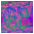

==> testing	


 512
[torch.LongStorage of size 1]

1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



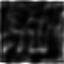

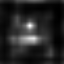

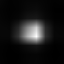

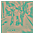

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/002_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/002_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/002_3.txt	


<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



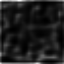

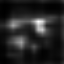

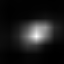

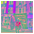

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/003_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/003_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/003_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



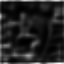

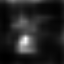

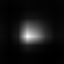

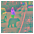

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/004_1.txt	


<csv>	writing done	


<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/004_2.txt	


<csv>	writing done	


<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/004_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



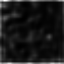

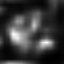

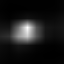

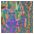

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/005_1.txt	


<csv>	writing done	


<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/005_2.txt	
<csv>	writing done	


<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/005_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



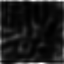

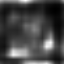

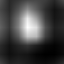

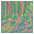

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/006_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/006_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/006_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



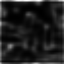

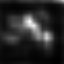

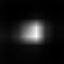

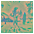

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/007_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/007_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/007_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



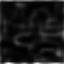

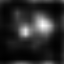

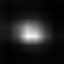

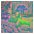

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/008_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/008_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/008_3.txt	


<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



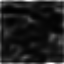

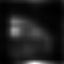

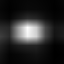

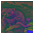

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/009_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/009_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/009_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



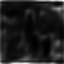

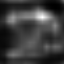

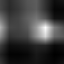

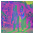

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/010_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/010_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/010_3.txt	
<csv>	writing done	


 512
[torch.LongStorage of size 1]



1e-06 *
-1.8906
-1.4387
 2.3741
 0.6328
-1.0774
[torch.CudaTensor of size 5]



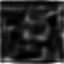

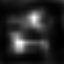

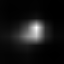

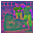

<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/011_1.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/011_2.txt	


<csv>	writing done	
<csv>	writing to file: logs_objdiscodata_trial/vgg_conv_atten_e-7_3levels_1global_concat/011_3.txt	
<csv>	writing done	


Test accuracy:	0	


In [9]:
for i=1,1 do --cmd_params.max_epoch do
  test()
end